# House Price Prediction with Linear Regression (NumPy-Only)

Predicting house prices is a classic machine learning problem — simple on the surface, but rich in practical insight. In this project, we’ll build a linear regression model **from scratch** using only **NumPy** and **Pandas** only for data loading and exploration., without relying on high-level ML libraries like scikit-learn or TensorFlow.

We'll use the [Seattle House Price Prediction dataset](https://www.kaggle.com/datasets/samuelcortinhas/house-price-prediction-seattle) from Kaggle, which contains features like square footage, number of bedrooms, and zip code to predict the price of a house.

This project will walk through:
- Loading and preprocessing real-world data
- Implementing the cost function and gradient descent from scratch
- Applying feature scaling for stable training
- Visualizing the model's learning progress
- Making predictions and evaluating performance

> **Why build from scratch?**  
> Anyone can `.fit()` a model, but writing the algorithm manually shows true understanding — something recruiters and hiring managers value highly. It's also the best way to demystify what's happening under the hood of machine learning.

Let's get started!

## Step 1: Import Libraries

In [17]:
import numpy as np  # Numerical operations
import pandas as pd  # Data manipulations
import matplotlib.pyplot as plt  # Data visualizations
import seaborn as sns  # Advanced visualizations
import math  # Mathematical functions

sns.set(style='white')

## Step 2: Load and Explore the Dataset

To begin, we load the dataset containing real-world housing data from Seattle, WA. This dataset includes features such as square footage, number of bedrooms, location (zip code), and more — all of which influence the price of a house.

Let's load the data and take a first look at its structure.

### 2.1 Load Dataset

Let’s load the dataset using Pandas.

In [3]:
# Loading the dataset from the csv file 
df = pd.read_csv('seattle-housing-data.csv')

# Preview first few rows
df.head()

,beds,baths,size,size_units,lot_size,lot_size_units,zip_code,price
0,3,3.0,2850.0,sqft,4200.00,sqft,98119,1175000.0
1,4,5.0,3040.0,sqft,5002.00,sqft,98106,1057500.0
2,3,1.0,1290.0,sqft,6048.00,sqft,98125,799000.0
3,3,2.0,2360.0,sqft,0.28,acre,98188,565000.0
4,3,3.5,1942.0,sqft,1603.00,sqft,98107,1187000.0


### 2.2 Understanding the Data

Before we begin modeling, it's crucial to understand the structure and quality of the dataset. This step helps us:

- Check how many samples and features we have
- Identify any missing values or anomalies
- Data types

Exploratory steps like these ensure that we don't feed incomplete or misleading data into our model.

In [4]:
# Get a concise summary of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   beds            505 non-null    int64  
 1   baths           505 non-null    float64
 2   size            505 non-null    float64
 3   size_units      505 non-null    object 
 4   lot_size        428 non-null    float64
 5   lot_size_units  428 non-null    object 
 6   zip_code        505 non-null    int64  
 7   price           505 non-null    float64
dtypes: float64(4), int64(2), object(2)
memory usage: 31.7+ KB


## Step 3: Data Cleaning

Our dataset is fairly simple, but still needs some cleaning to ensure the features are usable in a linear regression model.

Key issues identified:
- The `lot_size` column uses **mixed units** (`sqft` and `acre`), which need to be standardized
- The `size` column uses a separate `size_units` column — we should ensure all sizes are in **square feet**
- Some rows contain **missing values**
- We'll keep only the features that make sense for price prediction, and drop unit-related columns after standardization

Let’s clean the data accordingly.


### 3.1 Checking for Duplicates

Sometimes, datasets contain the exact same row more than once, maybe a property was accidentally logged twice or included in multiple records. If we don’t remove these duplicates, our model will give extra weight to those repeated rows, biasing the results.

In [5]:
# Check duplicates
print(f'Duplicates rows: {df.duplicated().sum()}')

Duplicates rows: 1


In [6]:
# Drop duplicates
df = df.drop_duplicates()

### 3.2 Fix Missing Values and Standardize Columns

Missing data is another common issue. In our dataset, we’ve already noticed that the `lot_size` and `lot_size_units` columns don’t have complete information for every house. If we ignore this, the model might crash or learn incorrect patterns.

There are several ways to deal with missing values:
- Dropping rows that are incomplete.
- Filling them in (imputation) using averages, medians, or even more advanced techniques.

The right choice depends on how important the column is and how much data is missing. For this case, the important column for us is the `lot_size`. We will fill the missing values with the median, but first we need to make the column values consistent since it has a mix of `sqft` and `acre`.

In [7]:
# Remove empty string on categorical variables which can be seen as null values
categorical_cols = df.select_dtypes(include='object').columns
df[categorical_cols] = df[categorical_cols].replace(r'^\s*$', np.nan, regex=True)

# Check for null values
print(df.isnull().sum())

beds               0
baths              0
size               0
size_units         0
lot_size          77
lot_size_units    77
zip_code           0
price              0
dtype: int64


In [8]:
# Create column 'lot_size_sqft' with standardized sqft units
df['lot_size_sqft'] = df.apply(
    lambda row: row['lot_size'] * 43560 if row['lot_size_units'] == 'acre' else row['lot_size'], axis=1
)

# Fill missing values with median
lot_size_median = df['lot_size_sqft'].median()
df['lot_size_sqft'] = df['lot_size_sqft'].fillna(lot_size_median)

# Rename 'size' column
df = df.rename(columns={'size': 'size_sqft'})

# Drop the unnecessary columns
df = df.drop(columns=['lot_size', 'lot_size_units', 'size_units'])

## Step 4: Exploratory Data Analysis (EDA)

Once our data is cleaned, the next step is to explore it. EDA is like detective work: we’re trying to uncover patterns, relationships, and potential problems in the data before we build any models.

The goal here isn’t just to generate pretty charts, it’s to understand how the features behave, how they relate to the target variable (`price`), and whether there are any issues (like outliers or skewed distributions) that could confuse our model.

We’ll look at the data in three stages: univariate (one variable at a time), bivariate (two variables), and multivariate (many variables together).


### 4.1 Univariate Analysis of Target Variable (price)

We’ll start by focusing on our target variable: `price`. Since our whole project is about predicting house prices, it makes sense to deeply understand what those prices look like in the dataset.

#### 4.1.1 Statistical Information

The `.describe()` method gives us basic summary statistics — mean, median, minimum, maximum, and quartiles. This quick snapshot helps us see whether house prices are generally high, low, or spread out across a wide range.

In [11]:
df['price'].describe().to_frame().T.style.format("{:,.0f}")

,count,mean,std,min,25%,50%,75%,max
price,504,"979,542","609,080","170,000","619,742","840,000","1,156,250","6,250,000"


Looking at the summary statistics for price, a few things stand out:

- There are 504 houses in our dataset.
- The average (mean) price is about &dollar;979,500, but the median (50%) price is lower at &dollar;840,000. This gap suggests that there are some very expensive homes pulling the mean upwards.
- Most homes fall between &dollar;620,000 (25th percentile) and &dollar;1,156,000 (75th percentile).
- The cheapest home is priced at &dollar;170,000, while the most expensive reaches an eye-popping &dollar;6.25 million.
- The standard deviation is very high (~&dollar;609,000), which tells us house prices vary a lot across the dataset.
In short, Seattle’s housing market is highly varied, with most homes clustered under $1.2M, but a handful of luxury properties driving up the average.

#### 4.1.2 Check for Outliers

Outliers are unusually high or low values that don’t fit the general trend. For house prices, these might be ultra-luxury homes worth millions, which could distort the scale of our model. Spotting and handling them is important because linear regression is sensitive to extreme values.

In [13]:
q1 = df['price'].quantile(0.25)
q3 = df['price'].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
outliers = df[(df['price'] < lower) | (df['price'] > upper)]['price']
print(f'Outliers: {len(outliers)}')

Outliers: 31


When we checked for outliers in the price column, we found 31 houses that stand far outside the typical price range. These are mostly ultra-luxury properties worth millions, compared to the majority of homes priced under $1.2M.

Outliers aren’t “bad data” — they’re real houses — but they can heavily influence a linear regression model, pulling the regression line towards them. That’s why it’s important to identify them now. Later, we’ll decide whether to keep them (if they’re relevant for prediction) or remove them (if they distort the model too much).

#### 4.1.3 Check for skewness

Skewness tells us whether the distribution of prices leans heavily to the left (a few very cheap homes) or to the right (a few extremely expensive homes). Since linear regression assumes normally distributed errors, a highly skewed target variable could affect model performance.

In [15]:
# Check for skewness
print(f'Skewness: {df['price'].skew():,.2f}')

Skewness: 2.89


Since our skewness is **2.89**, that’s strong positive skewness. This means most Seattle homes are clustered in the lower-to-mid price ranges, but a handful of very expensive luxury houses stretch the distribution to the right.

This also explains why the mean price (&dollar;979K) is higher than the median price (&dollar;840K) — those multi-million-dollar homes are pulling the average upward.

#### 4.1.4 Distribution of the price variable

Finally, we’ll visualize house prices using a histogram (or histplot in Seaborn). This gives us a clear picture of how prices are spread out, whether most homes fall into a certain price range or whether the distribution is uneven.

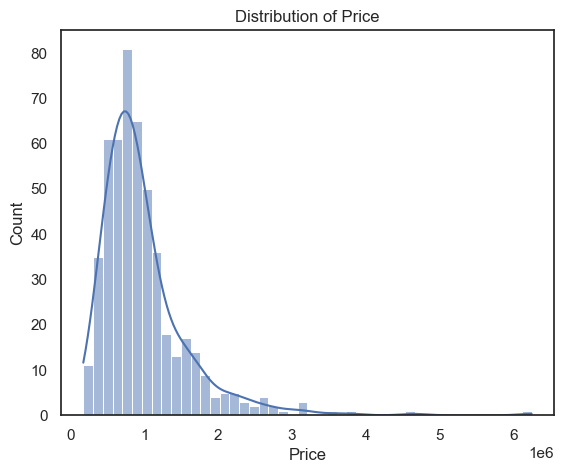

In [18]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['price'], kde=True)
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

### 4.2 Bivariate Analysis of Numerical Values vs. Target (price)

Once we understand the target, the next step is to explore how other numerical variables (like beds, baths, size, lot_size) relate to price.

#### 4.2.1 Correlation Heatmap

A correlation heatmap gives us a bird’s-eye view of relationships between variables. For instance, we might find that:
- size has a strong positive correlation with price (bigger homes → more expensive).
- beds and size are also strongly correlated (bigger houses usually mean more bedrooms).

This helps us identify which variables are likely to be the strongest predictors, and also warns us about multicollinearity (when two features are so closely related that they could confuse the model).

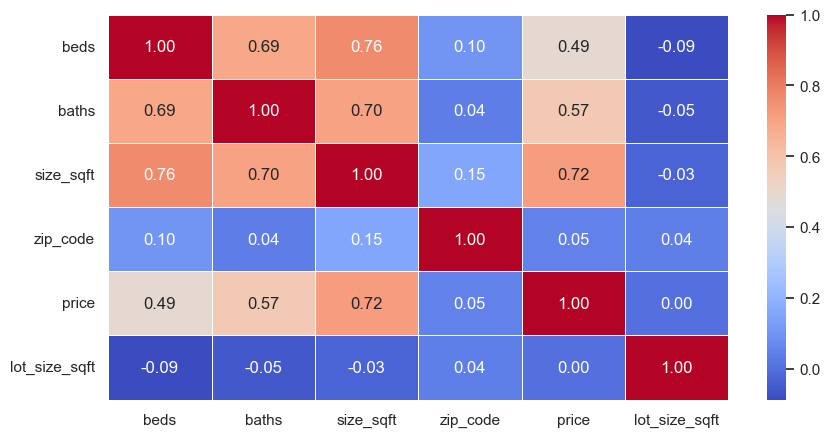

In [20]:
corr_mat = df.corr()
plt.figure(figsize=(10, 5))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.yticks(rotation=0)
plt.show()

Key insights include:

- size_sqft had the strongest linear relationship with price.
- beds and baths were step-wise (less ideal for simple linear regression).
- `lot_size_sqft` was noisy, bigger lots didn’t always mean higher prices.

#### 4.2.2 Scatter plot
Scatter plots are one of the most powerful ways to see relationships between a single feature and the target. For example:

- `size` vs. `price`: Do bigger houses generally cost more?
- `beds` vs. `price`: Does adding bedrooms always increase price, or is there a limit?

By plotting these, we can spot patterns (linear or non-linear) and also detect if some variables don’t really influence price much at all.

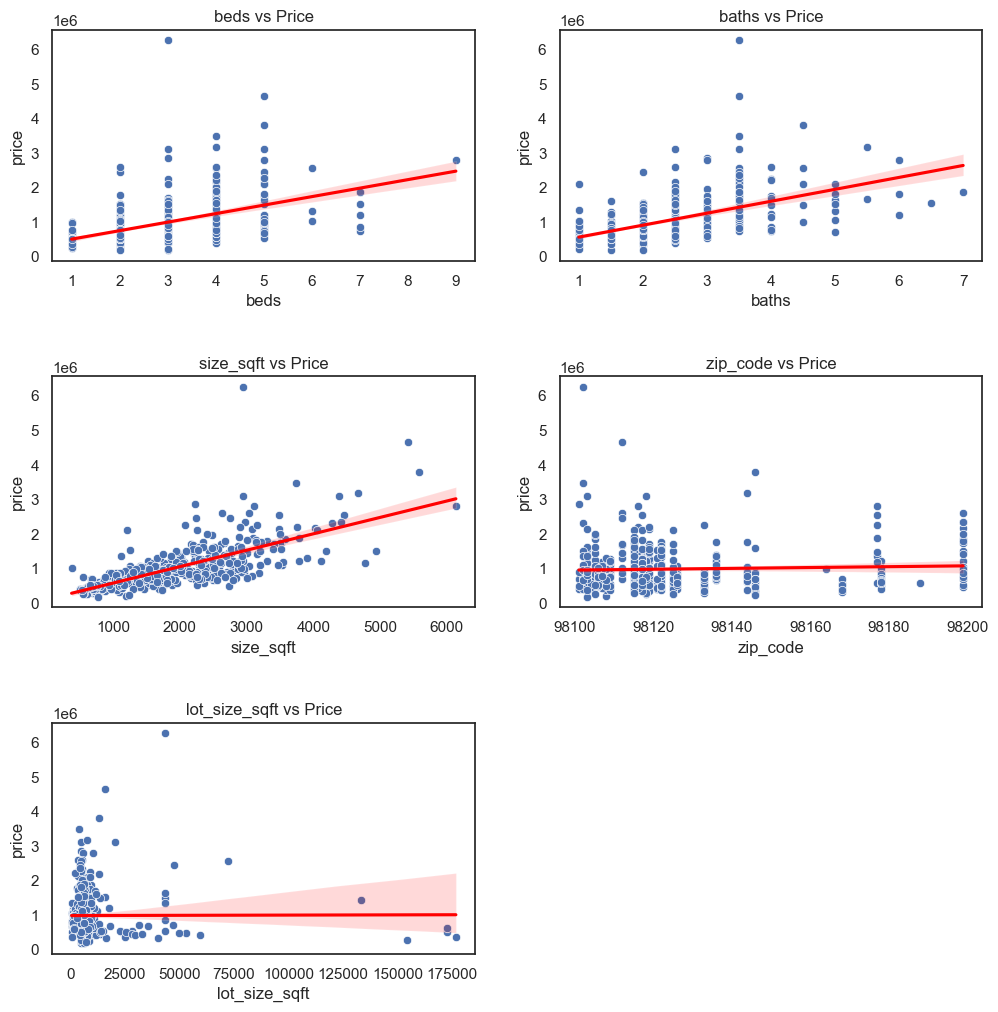

In [21]:
numerical_cols = df.columns.drop(['price'])

n_cols = 2
n_rows = math.ceil(len(numerical_cols) / n_cols)
plt.figure(figsize=(6 * n_cols, 4 * n_rows))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.scatterplot(data=df, x=col, y='price')
    plt.title(f'{col} vs Price')
    sns.regplot(
        x=col,
        y="price",
        data=df,
        scatter=False,
        color="red",
    )

plt.subplots_adjust(hspace=0.5, wspace=0.2)
plt.show()

**Decision:** We’d use `size` as the primary feature for the model.

## Step 2: Implementing Linear Regression from Scratch

### 2.1 Feature Scaling (Standardization)

Before training our linear regression model, it's important to scale our input features. This is especially critical when using **gradient descent**, as it ensures faster and more stable convergence.

We'll use **Z-score standardization**, which transforms our feature `X` into a distribution with:
- Mean = 0
- Standard deviation = 1

The formula is:

$$
X_{\text{scaled}} = \frac{X - \mu}{\sigma}
$$


Where:
- $\mu$ is the mean of the feature
- $\sigma$ is the standard deviation of the feature

This ensures the feature values are on the same scale, making gradient descent more effective.

In [23]:
# Extract the feature and target
X = df['size_sqft']
y = df['price']

# Extract the feature and target
x_mean = X.mean()
x_std = X.std()
X_scaled = (X - x_mean) / x_std

y_mean = y.mean()
y_std = y.std()
y_scaled = (y - y_mean) / y_std

# Print results
print(f"Mean of X: {x_mean:.2f}")
print(f"Standard Deviation of X: {x_std:.2f}")
print(f"First 5 scaled values: {X_scaled[:5]}")

print(f"\nMean of y: {y_mean:.2f}")
print(f"Standard Deviation of y: {y_std:.2f}")
print(f"First 5 scaled values: {y_scaled[:5]}")

Mean of X: 1854.77
Standard Deviation of X: 921.12
First 5 scaled values: 0    1.080454
1    1.286724
2   -0.613136
3    0.548493
4    0.094698
Name: size_sqft, dtype: float64

Mean of y: 979541.65
Standard Deviation of y: 609079.76
First 5 scaled values: 0    0.320908
1    0.127994
2   -0.296417
3   -0.680603
4    0.340609
Name: price, dtype: float64


### 2.2 Cost Function – Mean Squared Error (MSE)

To train our linear regression model, we need a way to measure **how well our model's predictions match the actual values**. This is the role of the **cost function**.

The most commonly used cost function for regression is the **Mean Squared Error (MSE)**:

$$
J(w, b) = \frac{1}{2m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)})^2
$$

Where:
- $ m $ is the number of training examples
- $ \hat{y}^{(i)} = w \cdot x^{(i)} + b $ is the predicted value for the i-th example
- $ y^{(i)} $ is the actual target value
- $ w $ is the weight (slope), and $ b $ is the bias (intercept)

>  We include the factor $ \frac{1}{2} $ to simplify the derivative during gradient descent.

This function calculates the **average squared difference** between predicted and actual values — lower is better.


In [24]:
# Define the cost function
def compute_cost(x_train, y_train, w, b):
    """
    Compute the Mean Squared Error cost function.
    
    Parameters:
    x_train (array): Input features (scaled)
    y_train (array): Actual target values
    w (float): Weight (slope)
    b (float): Bias (intercept)

    Returns:
    float: Cost J(w, b)
    """

    m = len(y)
    y_hat = np.dot(x_train, w) + b
    cost = (1 / (2 * m)) * np.sum((y_hat - y_train) ** 2)
    return cost

### 2.3 Gradient Descent

Now that we can measure the model's error using the cost function (MSE), we need a way to **minimize** that error. This is where **Gradient Descent** comes in.

Gradient Descent is an optimization algorithm that iteratively adjusts the model parameters (weight `w` and bias `b`) to **move in the direction that reduces the cost**.

<br>

#### Update Rules:

$$
w := w - \alpha \cdot \frac{\partial J}{\partial w}
$$
$$
b := b - \alpha \cdot \frac{\partial J}{\partial b}
$$

Where:
- $ \alpha $ is the learning rate, (how big each step is)
- $ \frac{\partial J}{\partial w} $, $ \frac{\partial J}{\partial b} $ are the **gradients** of the cost function with respect to `w` and `b`

#### Intuition:
- The gradients tell us **how steep the slope is** (how fast cost is increasing)
- We move in the **opposite direction of the slope** to minimize cost


In [25]:
# Define the gradient descent function
def gradient_descent(x_train, y_train, w, b, learning_rate, iterations):
    """
    Performs batch gradient descent to learn w and b.

    Parameters:
    x_train (array): Input features (scaled)
    y_train (array): Target values
    w (float): Initial weight
    b (float): Initial bias
    learning_rate (float): Step size for each update
    iterations (int): Number of training iterations

    Returns:
    w, b (float): Learned parameters
    cost_history (list): Cost at each iteration
    """
    m = len(y)
    cost_history = []

    for i in range(iterations):
        y_hat = np.dot(x_train, w) + b
        error = y_hat - y_train

        # Compute gradients
        dw = (1 / m) * np.dot(error, x_train)
        db = (1 / m) * np.sum(error)

        # Update parameters
        w -= learning_rate * dw
        b -= learning_rate * db

        # Track cost
        cost = compute_cost(x_train, y_train, w, b)

        if i % 100 == 0 or i == iterations - 1:
            print(f"Iteration {i}: Cost = {cost:.2f}, w = {w:.4f}, b = {b:.4f}")

        if i != 0 and abs(cost - cost_history[-1]) < 1e-06:
            print(f"Converged at iteration {i}")
            break

        cost_history.append(cost)
    return w, b, cost_history

### 2.4 Train the Model Using Gradient Descent
We now need to train the model using the gradient descent but first we need to set the hyperparameters

In [26]:
# Set hyperparameters
iterations = 10000
learning_rate = 0.001
initial_weight = 0
initial_bias = 0

# Train the model
final_weight, final_bias, cost_history = gradient_descent(X_scaled, y_scaled, initial_weight, initial_bias,
                                                          learning_rate, iterations)
print(f"Final Parameters: w = {final_weight:.4f}, b = {final_bias:.4f}")

Iteration 0: Cost = 0.50, w = 0.0007, b = 0.0000
Iteration 100: Cost = 0.45, w = 0.0689, b = 0.0000
Iteration 200: Cost = 0.41, w = 0.1305, b = 0.0000
Iteration 300: Cost = 0.38, w = 0.1863, b = 0.0000
Iteration 400: Cost = 0.36, w = 0.2368, b = 0.0000
Iteration 500: Cost = 0.34, w = 0.2825, b = 0.0000
Iteration 600: Cost = 0.32, w = 0.3239, b = 0.0000
Iteration 700: Cost = 0.31, w = 0.3613, b = 0.0000
Iteration 800: Cost = 0.29, w = 0.3952, b = 0.0000
Iteration 900: Cost = 0.28, w = 0.4258, b = 0.0000
Iteration 1000: Cost = 0.28, w = 0.4536, b = 0.0000
Iteration 1100: Cost = 0.27, w = 0.4787, b = 0.0000
Iteration 1200: Cost = 0.27, w = 0.5014, b = 0.0000
Iteration 1300: Cost = 0.26, w = 0.5220, b = 0.0000
Iteration 1400: Cost = 0.26, w = 0.5406, b = -0.0000
Iteration 1500: Cost = 0.25, w = 0.5574, b = -0.0000
Iteration 1600: Cost = 0.25, w = 0.5727, b = -0.0000
Iteration 1700: Cost = 0.25, w = 0.5864, b = -0.0000
Iteration 1800: Cost = 0.25, w = 0.5989, b = -0.0000
Iteration 1900: Cos

### 2.5 Predictions and Regression Line

With the model trained, we can now generate predictions for house prices using the learned parameters.

Since our model was trained on **standardized data**, we will:
1. Use the learned `w` and `b` to make predictions on `X_scaled`
2. Convert the predictions back to the **original price scale** using the inverse Z-score formula:
   $$
   \hat{y}_{\text{original}} = \hat{y}_{\text{scaled}} \times \sigma_y + \mu_y
   $$
3. Plot the regression line over the original data to visualize how well the model fits.

This will give us a clear view of how accurately our NumPy-based linear regression model captures the relationship between house size and price.


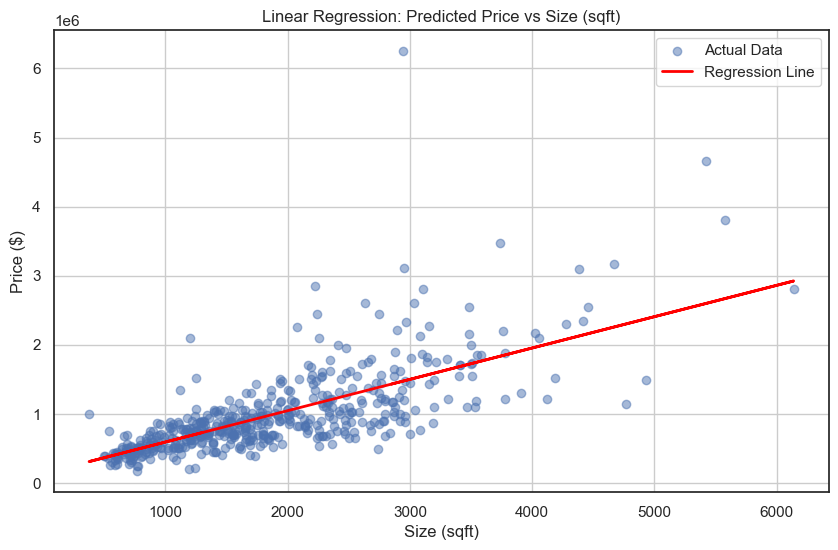

In [27]:
# Step 1: Predict scaled prices
y_hat_scaled = final_weight * X_scaled + final_bias

# Step 2: Rescale predictions to original price range
y_hat = y_hat_scaled * y_std + y_mean

# Step 3: Plot actual data vs predicted line
plt.figure(figsize=(10, 6))
plt.scatter(X, y, label='Actual Data', alpha=0.5)
plt.plot(X, y_hat, color='red', label='Regression Line', linewidth=2)
plt.title('Linear Regression: Predicted Price vs Size (sqft)')
plt.xlabel('Size (sqft)')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

### 2.6 Model Evaluation: RMSE and R² Score

After training and visualizing the model's fit, we now want to **quantify its performance**.

We'll use two standard regression metrics

<br>

#### 1. **RMSE (Root Mean Squared Error)**  
Measures the average prediction error in the same units as the target variable (price in dollars):

$$
\text{RMSE} = \sqrt{ \frac{1}{m} \sum_{i=1}^{m} (\hat{y}_i - y_i)^2 }
$$

Lower RMSE = better fit.

<br>

#### 2. **R² Score (Coefficient of Determination)**  
Represents the proportion of variance in the target explained by the model:

$$
R^2 = 1 - \frac{ \sum (\hat{y} - y)^2 }{ \sum (y - \bar{y})^2 }
$$

- $ R^2 = 1.0 $: perfect prediction  
- $ R^2 = 0.0 $: model predicts the mean  
- $ R^2 < 0 $: worse than guessing the mean

Let’s compute both to evaluate how well our NumPy-based linear regression model performs.


In [28]:
# Importing Scikit-Learn library that we will use for our evaluation
from sklearn.metrics import mean_squared_error, r2_score

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y, y_hat))

# Compute R² score
r2 = r2_score(y, y_hat)

# Display results
print(f"RMSE: ${rmse:,.2f}")
print(f"R² Score: {r2:.4f}")

RMSE: $424,104.61
R² Score: 0.5142


## Final Summary & Reflections

In this project, we built a **linear regression model from scratch using NumPy** to predict house prices in Seattle. We worked step by step through the full machine learning pipeline, including:

- **Data cleaning & preprocessing** (unit standardization, missing value handling)
- **Exploratory data analysis** (scatter plots, correlation checks)
- **Feature scaling** using Z-score normalization
- **Model implementation**: cost function (MSE), gradient descent
- **Model training and prediction** with visualization
- **Model evaluation** using RMSE and R² Score

<br>

### Key Learnings

- Implementing algorithms from scratch is the best way to deeply understand how they work
- Feature selection significantly impacts model performance
- Standardizing data is crucial when using gradient descent
- Real-world data is messy — handling units, missing values, and scale differences is essential
- Evaluation metrics tell the **real story** about a model’s performance